In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [4]:
# Save the input and target variables

data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [7]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis=0)) / targets.std()
targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [9]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [10]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    
    return model

model = get_model()

In [11]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [16]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [17]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                   validation_split=0.15, batch_size=64, verbose=False)

In [18]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5640 - mae: 0.5068


[0.44832286304897734, 0.5068482]

#### Plot the learning curves

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

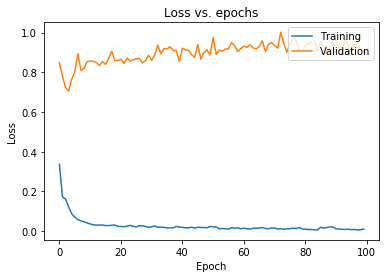

In [21]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [22]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [24]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),  activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),  activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),  activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),  activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),  activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [25]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5, 0.3)

In [26]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [28]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                   validation_split=0.15, batch_size=64, verbose=False)

In [29]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5285 - mae: 0.5614


[0.499225562148624, 0.5613652]

#### Plot the learning curves

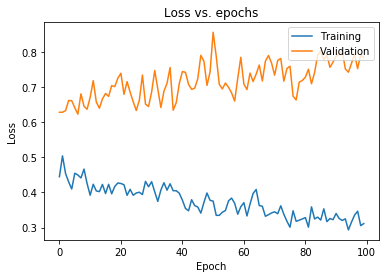

In [30]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [54]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting predicting....")
        
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Predicting: Starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Predicting: Finished batch {batch}")
        
    def on_predict_end(self, logs=None):
        print("Finished predicting!")

In [49]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [50]:
# Compile the model

model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [51]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs=3,
         batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting training....
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training!


In [53]:
# Evaluate the model

model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])

Starting testing....
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing!


0.9683534834120009

In [55]:
# Make predictions with the model

model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Starting predicting....
Predicting: Starting batch 0
Predicting: Finished batch 0
Predicting: Starting batch 1
Predicting: Finished batch 1
Finished predicting!


array([[-0.02147118],
       [-0.04861256],
       [ 0.00394745],
       [-0.04833598],
       [-0.04855832],
       [ 0.03747886],
       [-0.04176188],
       [ 0.04905582],
       [-0.0479755 ],
       [-0.0195973 ],
       [ 0.01034436],
       [-0.03678315],
       [ 0.04865525],
       [-0.04988956],
       [-0.05077606],
       [ 0.06219269],
       [-0.04986936],
       [ 0.00328203],
       [ 0.06644223],
       [ 0.00569193],
       [-0.05303898],
       [-0.05222414],
       [ 0.01295911],
       [-0.01167349],
       [-0.03822076],
       [ 0.02930085],
       [-0.03739628],
       [ 0.05094001],
       [-0.04418337],
       [-0.00044187],
       [-0.03462587],
       [-0.02878534],
       [ 0.02415689],
       [-0.04862903],
       [-0.03237265],
       [ 0.05763669],
       [-0.05078731],
       [ 0.02861424],
       [ 0.02785162],
       [ 0.02983424],
       [-0.05224362],
       [ 0.05510032],
       [-0.04444306],
       [-0.02241911],
       [ 0.02851814]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [71]:
# Re-train the unregularised model

unregularized_model = get_model()
unregularized_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularized_model.fit(train_data, train_targets, epochs=100,
                                        validation_split=0.15, batch_size=64, verbose=False,
                                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [59]:
# Evaluate the model on the test set

unregularized_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.5385


0.5458926902876959

In [70]:
# Re-train the regularised model

regularized_model = get_regularised_model(1e-8, 0.2)
regularized_model.compile(optimzer='adam', loss='mse')
reg_history = regularized_model.fit(train_data, train_targets, epochs=100,
                     validation_split=0.15, batch_size=64, verbose=False,
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [64]:
# Evaluate the model on the test set

regularized_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.4802


0.5329366399182214

#### Plot the learning curves

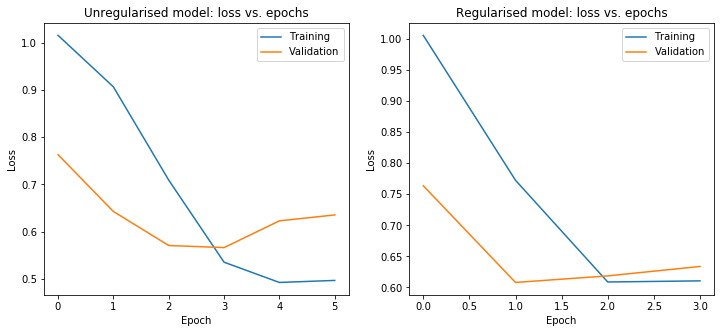

In [72]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()